In [1]:
from time import sleep
import json
from tqdm import tqdm
tqdm.pandas(desc='pandas')

import pandas as pd
import numpy as np
from dask import dataframe as dd

from geopy.geocoders import Nominatim
geoEncoder = Nominatim(user_agent='spanish-cities')

def getCoords(name: str):
    try:
        geoInfo = geoEncoder.geocode(f'{name}, Spain').raw
        return float(geoInfo['lat']), float(geoInfo['lon'])
            
    except:
        return np.nan, np.nan
        
def backup(dic, path):
    with open(path,'w') as f:
        json.dump(obj=dic, fp=f, indent=4)

def restore(path):
    with open(path) as f:
        return json.load(f)

C:\Users\astro\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## city associations

### get glovo city coords

In [7]:
df = pd.read_csv('glovo_cities.csv', index_col=0)
glovoCityCoords = dict.fromkeys(list(df.city_name), None)

In [8]:
for city in tqdm(glovoCityCoords.keys()):
    sleep(1.5)

    glovoCityCoords[city] = getCoords(city)
    

glovoCityCoords

100%|██████████| 312/312 [09:00<00:00,  1.73s/it]


{'Madrid': (40.4167047, -3.7035825),
 'Valencia': (39.4697065, -0.3763353),
 'Barcelona': (41.3828939, 2.1774322),
 'Sevilla': (37.3886303, -5.9953403),
 'Zaragoza': (41.6521342, -0.8809428),
 'Malaga': (36.7213028, -4.4216366),
 'Palma': (39.5695818, 2.6500745),
 'Las Palmas de Gran Canaria': (28.1288694, -15.4349015),
 'Tenerife': (28.2935785, -16.621447121144122),
 'Alcalá de Henares y Torrejón de Ardoz': (nan, nan),
 'Leganés - Getafe': (40.3141049, -3.7416838),
 'Vigo': (42.2376602, -8.7247205),
 'Granada': (37.1734995, -3.5995337),
 'Córdoba': (37.8845813, -4.7760138),
 'Oviedo': (43.3604218, -5.8450534),
 'Sabadell': (41.5421013, 2.1138977),
 'Valladolid': (41.6521328, -4.728562),
 'Bilbao': (43.2630018, -2.9350039),
 'Pamplona': (42.8184538, -1.6442556),
 'Santander': (43.4620412, -3.8099719),
 'Sant Cugat del Vallès y Rubí': (nan, nan),
 'A Coruña': (43.3709703, -8.3959425),
 'Vitoria': (42.8465088, -2.6724025),
 'Murcia': (37.9923795, -1.1305431),
 'Terrassa': (41.5629623, 2.

In [9]:
backup(glovoCityCoords, 'glovoCityCoords.json')

### find closest glovo city for all census towns

In [23]:
def distance(coords1: tuple, coords2: tuple):
    return np.sqrt((coords1[0] - coords2[0])**2  +  (coords1[1] - coords2[1])**2)

def closestGlovoCity(testCoords: tuple):
    theFavourite = ('', np.inf)

    for city, coords in glovoCityCoords.items():
        d = distance(testCoords, coords)

        if d < theFavourite[1]:
            theFavourite = (city, d)

    return theFavourite[0]

In [45]:
censusCities = pd.read_excel('../aux_data/01_census/data/provincial and municipal codes.xlsx')
censusCities

,CODAUTO,CPRO,CMUN,DC,NOMBRE
0,16,1,1,4,Alegría-Dulantzi
1,16,1,2,9,Amurrio
2,16,1,3,5,Aramaio
3,16,1,4,0,Artziniega
4,16,1,6,6,Armiñón
...,...,...,...,...,...
8126,2,50,296,7,"Zaida, La"
8127,2,50,297,3,Zaragoza
8128,2,50,298,9,Zuera
8129,18,51,1,3,Ceuta


In [49]:
censusCityCoords = dict.fromkeys(list(censusCities.NOMBRE), np.nan)
censusCitiesClosestGlovo = dict.fromkeys(list(censusCities.NOMBRE), np.nan)

for city in tqdm(censusCityCoords.keys()):
    sleep(1.5)

    coords = getCoords(city)
    censusCityCoords[city] = coords

    censusCitiesClosestGlovo[city] = closestGlovoCity(coords)



100%|██████████| 8114/8114 [3:51:40<00:00,  1.71s/it]  


In [50]:
backup(censusCitiesClosestGlovo, 'censusCitiesClosestGlovo.json')
backup(censusCityCoords, 'censusCityCoords.json')

### create autonomous community polygons

In [2]:
import geopandas as gpd
from shapely.ops import unary_union
import pyproj
import matplotlib.pyplot as plt

#### davood shapefile

In [3]:
mun = gpd.read_file('data/davood_municipalities/MUNICIPIOS89.shp')
mun.head()

,OBJECTID,Codigo,Texto,Cod_Prov,Cod_CCAA,FechaId,NUTS_0,NUTS_1,NUTS_2,NUTS_3,...,PAD_3C95,PAD_3C96,PAD_3C97,PAD_3C98,PAD_3C99,PAD_3_COD_,PAD_3_CO_1,Shape__Are,Shape__Len,geometry
0,1,01001,Alegría-Dulantzi,01,16,01012017,ES,ES2,ES21,ES211,...,0.0,18.0,1.0,0.0,1.0,01,16,3.709269e+07,48191.568751,"MULTIPOLYGON (((-2.53469 42.82247, -2.53412 42..."
1,2,01002,Amurrio,01,16,01012017,ES,ES2,ES21,ES211,...,0.0,58.0,1.0,2.0,5.0,01,16,1.799114e+08,90623.621773,"MULTIPOLYGON (((-2.95561 42.98869, -2.95559 42..."
2,3,01003,Aramaio,01,16,01012017,ES,ES2,ES21,ES211,...,0.0,3.0,0.0,0.0,1.0,01,16,1.377066e+08,58592.915252,"POLYGON ((-2.52786 43.05149, -2.52783 43.05142..."
3,4,01004,Artziniega,01,16,01012017,ES,ES2,ES21,ES211,...,1.0,8.0,0.0,0.0,2.0,01,16,5.130078e+07,31498.523574,"POLYGON ((-3.10886 43.14338, -3.10887 43.14331..."
4,5,01006,Armiñón,01,16,01012017,ES,ES2,ES21,ES211,...,0.0,3.0,0.0,0.0,0.0,01,16,2.380288e+07,33293.805131,"MULTIPOLYGON (((-2.90185 42.69682, -2.90160 42..."


In [4]:
mun.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### census shapefile

In [110]:
# switched = pyproj.CRS('''PROJCS["ETRS89 / UTM zone 30N",
#     GEOGCS["ETRS89",
#         DATUM["European_Terrestrial_Reference_System_1989",
#             SPHEROID["GRS 1980",6378137,298.257222101,
#                 AUTHORITY["EPSG","7019"]],
#             TOWGS84[0,0,0,0,0,0,0],
#             AUTHORITY["EPSG","6258"]],
#         PRIMEM["Greenwich",0,
#             AUTHORITY["EPSG","8901"]],
#         UNIT["degree",0.0174532925199433,
#             AUTHORITY["EPSG","9122"]],
#         AUTHORITY["EPSG","4258"]],
#     PROJECTION["Transverse_Mercator"],
#     PARAMETER["latitude_of_origin",0],
#     PARAMETER["central_meridian",-3],
#     PARAMETER["scale_factor",0.9996],
#     PARAMETER["false_easting",500000],
#     PARAMETER["false_northing",0],
#     UNIT["metre",1,
#         AUTHORITY["EPSG","9001"]],
#     AXIS["Easting",WEST],
#     AXIS["Northing",NORTH],
#     AUTHORITY["EPSG","25830"]]''')

# switched

<Bound CRS: PROJCS["ETRS89 / UTM zone 30N",
    GEOGCS["ETRS89 ...>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- [west]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from ETRS89 to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Source CRS: ETRS89 / UTM zone 30N

In [6]:
mun = gpd.read_file('data/map_municipalities/SECC_CPV_E_20111101_01_R_INE.shp').to_crs(epsg=4326) #.set_crs(switched, allow_override=True) # convert to lat, lon
mun.head()

,OBJECTID,CUSEC,CUMUN,CSEC,CDIS,CMUN,CPRO,CCA,CUDIS,OBS,...,CNUT2,CNUT3,CLAU2,NPRO,NCA,NMUN,Shape_Leng,Shape_area,Shape_len,geometry
0,1,0100101001,01001,001,01,001,01,16,0100101,None,...,1,1,01001,Araba/Álava,País Vasco,Alegría-Dulantzi,34474.734278,1.551393e+07,34474.734278,"MULTIPOLYGON (((-2.49116 42.85691, -2.49103 42..."
1,2,0100101002,01001,002,01,001,01,16,0100101,None,...,1,1,01001,Araba/Álava,País Vasco,Alegría-Dulantzi,8620.042319,4.410972e+06,8620.042319,"POLYGON ((-2.49361 42.85699, -2.49361 42.85699..."
2,3,0100201001,01002,001,01,002,01,16,0100201,None,...,1,1,01002,Araba/Álava,País Vasco,Amurrio,47379.027701,3.535737e+07,47379.027700,"MULTIPOLYGON (((-2.95561 42.98869, -2.95559 42..."
3,4,0100201002,01002,002,01,002,01,16,0100201,None,...,1,1,01002,Araba/Álava,País Vasco,Amurrio,31169.713203,3.873652e+07,31169.713203,"POLYGON ((-2.89021 43.04566, -2.89014 43.04547..."
4,5,0100201003,01002,003,01,002,01,16,0100201,None,...,1,1,01002,Araba/Álava,País Vasco,Amurrio,4244.249418,8.494741e+05,4244.249418,"POLYGON ((-3.00099 43.05210, -3.00185 43.05156..."


In [7]:
mun.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

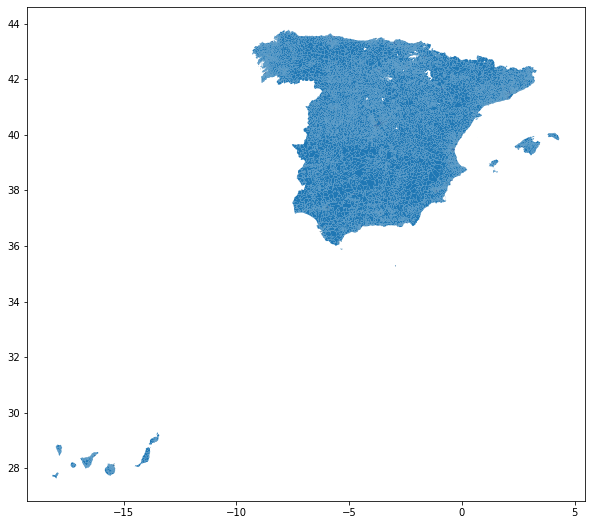

In [13]:
mun.plot(figsize=(10,10))

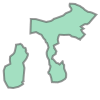

In [11]:
mun.iloc[0, -1]

In [15]:
mun.NMUN.nunique()

8101

In [18]:
ncas = list(mun.NCA.unique()) # nombre communidad autonoma?
ncas

['País Vasco',
 'Castilla-La Mancha',
 'Comunitat Valenciana',
 'Andalucía',
 'Castilla y León',
 'Extremadura',
 'Illes Balears',
 'Cataluña',
 'Galicia',
 'Pais Vasco',
 'Aragón',
 'La Rioja',
 'Comunidad de Madrid',
 'Región de Murcia',
 'Comunidad Foral de Navarra',
 'Principado de Asturias',
 'Canarias',
 'Cantabria',
 'Ceuta',
 'Melilla']

In [19]:
mun.NCA.nunique()

20

In [20]:
ncaDF = gpd.GeoDataFrame()


for nca in ncas:

    groupOfMuns = mun[mun.NCA == nca]
    geometries = list(groupOfMuns.geometry)

    ncaDF.loc[nca, 'geometry'] = unary_union(geometries)


ncaDF


,geometry
País Vasco,"MULTIPOLYGON (((-2.54903 42.48445, -2.55117 42..."
Castilla-La Mancha,"MULTIPOLYGON (((-2.21352 38.20181, -2.21351 38..."
Comunitat Valenciana,"MULTIPOLYGON (((-0.70531 37.94131, -0.70489 37..."
Andalucía,"MULTIPOLYGON (((-5.59892 36.01183, -5.59959 36..."
Castilla y León,"MULTIPOLYGON (((-5.18190 40.08771, -5.18274 40..."
Extremadura,"POLYGON ((-6.03816 37.99518, -6.03821 37.99515..."
Illes Balears,"MULTIPOLYGON (((3.00277 39.31736, 3.00260 39.3..."
Cataluña,"MULTIPOLYGON (((0.45575 40.54060, 0.45527 40.5..."
Galicia,"MULTIPOLYGON (((-7.42711 41.83294, -7.42902 41..."
Pais Vasco,"POLYGON ((-1.97163 43.30717, -1.97162 43.30718..."


c:\ProgramData\Anaconda3\envs\mapping\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


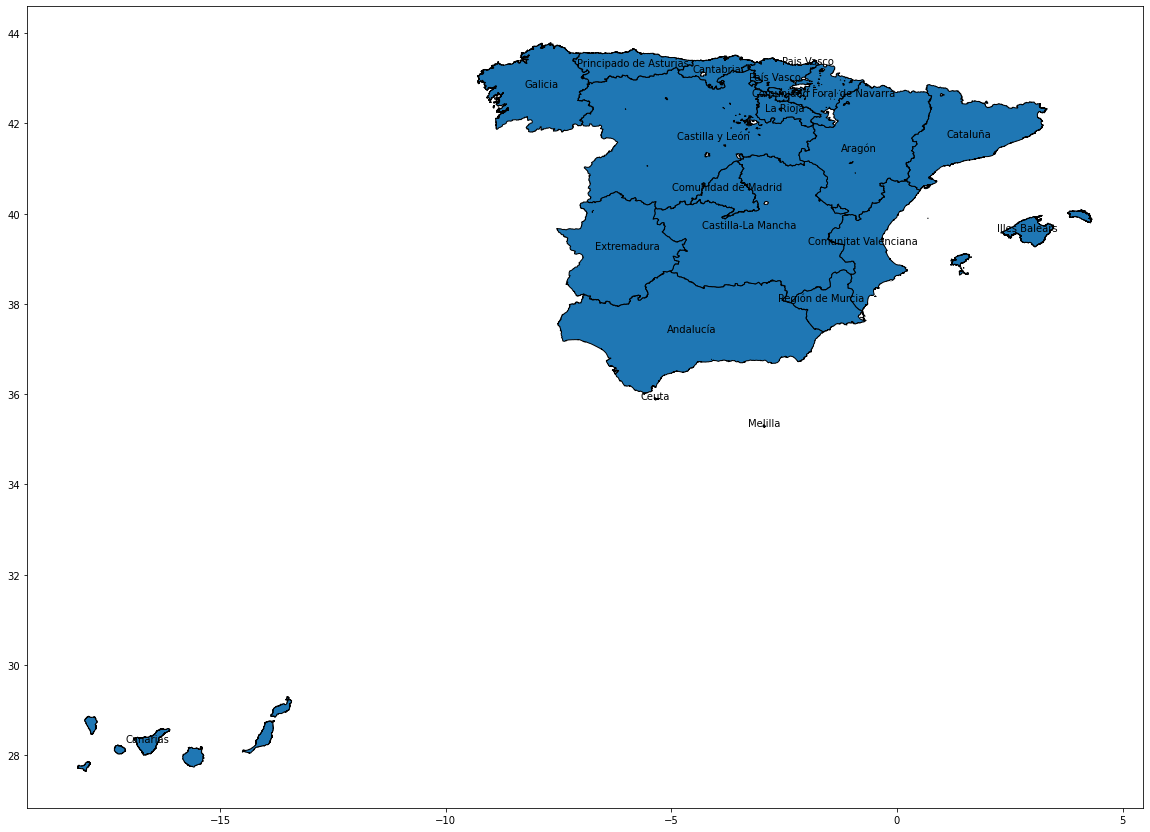

In [45]:
ncaDF.plot(figsize=(20,20), edgecolor='black', legend=True)
for index, row in ncaDF.iterrows():
    plt.annotate(
        s=index, 
        xy=(row.geometry.representative_point().x, row.geometry.representative_point().y),
        horizontalalignment='center',
        )

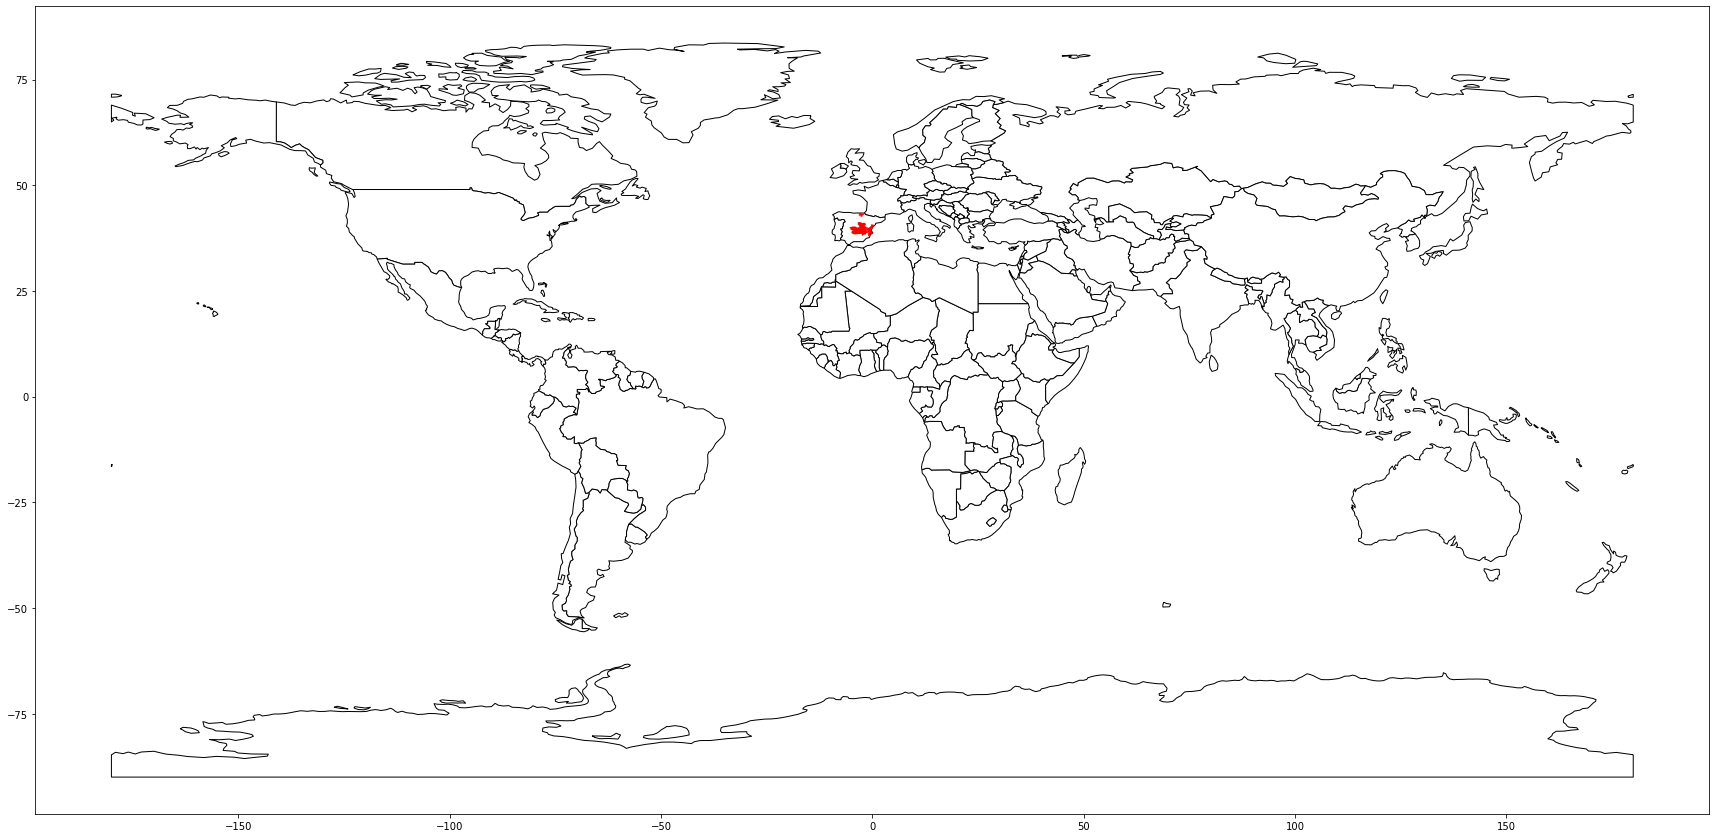

In [36]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(30, 30))
ncaDF[:3].plot(ax=ax, color='red')
plt.show()

<AxesSubplot:>

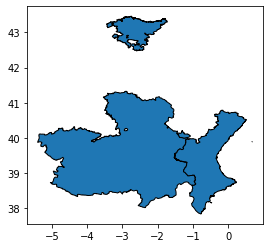

In [33]:
ncaDF[:3].plot(edgecolor='black')

In [76]:
ncaDF.to_file('data/map_autonomous_communities/autonomous_communities.shp')

### create association table

In [55]:
from shapely.geometry import Point, Polygon

In [49]:
ncaDF = gpd.read_file('data/map_autonomous_communities/autonomous_communities.shp').rename(columns={'index': 'NCA'}).set_crs(epsg=4326)
ncaDF

,NCA,geometry
0,País Vasco,"MULTIPOLYGON (((-2.54903 42.48445, -2.55117 42..."
1,Castilla-La Mancha,"MULTIPOLYGON (((-2.21352 38.20181, -2.21351 38..."
2,Comunitat Valenciana,"MULTIPOLYGON (((-0.70531 37.94131, -0.70489 37..."
3,Andalucía,"MULTIPOLYGON (((-5.59892 36.01183, -5.59959 36..."
4,Castilla y León,"MULTIPOLYGON (((-5.18190 40.08771, -5.18274 40..."
5,Extremadura,"POLYGON ((-6.03816 37.99518, -6.03821 37.99515..."
6,Illes Balears,"MULTIPOLYGON (((3.00277 39.31736, 3.00260 39.3..."
7,Cataluña,"MULTIPOLYGON (((0.45575 40.54060, 0.45527 40.5..."
8,Galicia,"MULTIPOLYGON (((-7.42711 41.83294, -7.42902 41..."
9,Pais Vasco,"POLYGON ((-1.97163 43.30717, -1.97162 43.30718..."


In [50]:
ncaDF.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [57]:
x,y = ncaDF.loc[0].geometry.representative_point().x, ncaDF.loc[0].geometry.representative_point().y

print(x,y)                                              ## FFS CONVENTION!!! https://geopandas.org/en/stable/docs/user_guide/projections.html#the-axis-order-of-a-crs - motherfUUUUUUUUCCKK stupid 'traditional' GIS order
ncaDF.loc[0].geometry.contains(Point(x,y))

-2.69572985145599 42.964733362575664


True

In [68]:
censusCitiesClosestGlovo = restore('censusCitiesClosestGlovo.json')
glovoCityCoords = restore('glovoCityCoords.json')

In [70]:
associationDF = (
    pd.Series(censusCitiesClosestGlovo)
    .to_frame()
    .reset_index()
    .rename(columns={'index': 'municipality', 0: 'closestGlovoCity'})
    .merge(
        pd.Series(glovoCityCoords).rename('glovoCityCoords'), 
        left_on='closestGlovoCity',
        right_index=True,
        how='inner',
        )
)
associationDF

,municipality,closestGlovoCity,glovoCityCoords
0,Alegría-Dulantzi,Vitoria,"[42.8465088, -2.6724025]"
5,Arratzua-Ubarrundia,Vitoria,"[42.8465088, -2.6724025]"
13,Zigoitia,Vitoria,"[42.8465088, -2.6724025]"
16,Elburgo/Burgelu,Vitoria,"[42.8465088, -2.6724025]"
27,Arraia-Maeztu,Vitoria,"[42.8465088, -2.6724025]"
...,...,...,...
7551,Plentzia,Getxo,"[43.3479409, -3.0087671]"
7556,Sopela,Getxo,"[43.3479409, -3.0087671]"
7562,Urduliz,Getxo,"[43.3479409, -3.0087671]"
8112,Ceuta,Ceuta,"[35.888361, -5.304138]"


In [79]:
def assignAutoCommunity(cityCoords: list):
    for index, row in ncaDF.iterrows():

        if row.geometry.contains(Point(cityCoords[1], cityCoords[0])):
            return row.NCA
        
    return np.nan



associationDF['autonomousCommunity'] = associationDF.glovoCityCoords.apply(assignAutoCommunity)
associationDF

,municipality,closestGlovoCity,glovoCityCoords,autonomousCommunity
0,Alegría-Dulantzi,Vitoria,"[42.8465088, -2.6724025]",País Vasco
5,Arratzua-Ubarrundia,Vitoria,"[42.8465088, -2.6724025]",País Vasco
13,Zigoitia,Vitoria,"[42.8465088, -2.6724025]",País Vasco
16,Elburgo/Burgelu,Vitoria,"[42.8465088, -2.6724025]",País Vasco
27,Arraia-Maeztu,Vitoria,"[42.8465088, -2.6724025]",País Vasco
...,...,...,...,...
7551,Plentzia,Getxo,"[43.3479409, -3.0087671]",País Vasco
7556,Sopela,Getxo,"[43.3479409, -3.0087671]",País Vasco
7562,Urduliz,Getxo,"[43.3479409, -3.0087671]",País Vasco
8112,Ceuta,Ceuta,"[35.888361, -5.304138]",Ceuta


In [80]:
associationDF.autonomousCommunity.value_counts(dropna=False)

Castilla y León               2119
Cataluña                       997
Castilla-La Mancha             872
Andalucía                      726
Comunitat Valenciana           661
Extremadura                    540
Aragón                         425
Galicia                        321
Comunidad Foral de Navarra     296
País Vasco                     260
Comunidad de Madrid            225
La Rioja                       223
Cantabria                      130
Canarias                        86
Principado de Asturias          79
Región de Murcia                68
Illes Balears                   65
NaN                              3
Melilla                          1
Ceuta                            1
Name: autonomousCommunity, dtype: int64

In [82]:
associationDF.to_excel('associationTable.xlsx')

## creating share of foreigners

### adding associated glovo-city

In [2]:
census = dd.read_parquet('../aux_data/01_census/data/locationSubset/').compute()
census.head()

,province code,Municipality code or size,Hole identifier,Final number of the person inside the hole,Person lift factor,Birth month,Year of birth,Age,Sex,Country code of nationality,...,core type,core size,Number of children,Number of common children of the kernel,Large family indicator,Type of partner (de facto or de jure),"Type of couple (same sex, different sex)",Age difference between male and female core,locationCode,location
2,1.0,59.0,65.0,1.0,12.585368,1.0,1915.0,96.0,1.0,108.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,6.0,01059,Vitoria-Gasteiz
3,1.0,59.0,65.0,2.0,12.585368,6.0,1923.0,88.0,6.0,108.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,6.0,01059,Vitoria-Gasteiz
4,1.0,59.0,138.0,1.0,14.037818,1.0,1917.0,94.0,1.0,108.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01059,Vitoria-Gasteiz
5,1.0,59.0,202.0,1.0,41.444004,1.0,1918.0,93.0,1.0,108.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01059,Vitoria-Gasteiz
6,1.0,59.0,202.0,2.0,41.444004,7.0,1964.0,47.0,1.0,341.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01059,Vitoria-Gasteiz


In [3]:
len(census)

2085622

In [4]:
associationDF = pd.read_excel('associationTable.xlsx', index_col=0)
associationDF

,municipality,closestGlovoCity,glovoCityCoords,autonomousCommunity
0,Alegría-Dulantzi,Vitoria,"[42.8465088, -2.6724025]",País Vasco
5,Arratzua-Ubarrundia,Vitoria,"[42.8465088, -2.6724025]",País Vasco
13,Zigoitia,Vitoria,"[42.8465088, -2.6724025]",País Vasco
16,Elburgo/Burgelu,Vitoria,"[42.8465088, -2.6724025]",País Vasco
27,Arraia-Maeztu,Vitoria,"[42.8465088, -2.6724025]",País Vasco
...,...,...,...,...
7551,Plentzia,Getxo,"[43.3479409, -3.0087671]",País Vasco
7556,Sopela,Getxo,"[43.3479409, -3.0087671]",País Vasco
7562,Urduliz,Getxo,"[43.3479409, -3.0087671]",País Vasco
8112,Ceuta,Ceuta,"[35.888361, -5.304138]",Ceuta


In [5]:
census = pd.merge(census, associationDF, left_on='location', right_on='municipality', how='left')
census.head()

,province code,Municipality code or size,Hole identifier,Final number of the person inside the hole,Person lift factor,Birth month,Year of birth,Age,Sex,Country code of nationality,...,Large family indicator,Type of partner (de facto or de jure),"Type of couple (same sex, different sex)",Age difference between male and female core,locationCode,location,municipality,closestGlovoCity,glovoCityCoords,autonomousCommunity
0,1.0,59.0,65.0,1.0,12.585368,1.0,1915.0,96.0,1.0,108.0,...,1.0,1.0,1.0,6.0,01059,Vitoria-Gasteiz,Vitoria-Gasteiz,Vitoria,"[42.8465088, -2.6724025]",País Vasco
1,1.0,59.0,65.0,2.0,12.585368,6.0,1923.0,88.0,6.0,108.0,...,1.0,1.0,1.0,6.0,01059,Vitoria-Gasteiz,Vitoria-Gasteiz,Vitoria,"[42.8465088, -2.6724025]",País Vasco
2,1.0,59.0,138.0,1.0,14.037818,1.0,1917.0,94.0,1.0,108.0,...,NaN,NaN,NaN,NaN,01059,Vitoria-Gasteiz,Vitoria-Gasteiz,Vitoria,"[42.8465088, -2.6724025]",País Vasco
3,1.0,59.0,202.0,1.0,41.444004,1.0,1918.0,93.0,1.0,108.0,...,NaN,NaN,NaN,NaN,01059,Vitoria-Gasteiz,Vitoria-Gasteiz,Vitoria,"[42.8465088, -2.6724025]",País Vasco
4,1.0,59.0,202.0,2.0,41.444004,7.0,1964.0,47.0,1.0,341.0,...,NaN,NaN,NaN,NaN,01059,Vitoria-Gasteiz,Vitoria-Gasteiz,Vitoria,"[42.8465088, -2.6724025]",País Vasco


In [6]:
len(census)

2085622

### create each glovo-city regions share of foreigners

In [7]:
colsOfInterest = ['closestGlovoCity', 'municipality', 'glovoCityCoords', 'autonomousCommunity', 'Age', 'Sex', 'Country code of nationality', 'Country of birth code']
byCity = census.groupby('closestGlovoCity')[colsOfInterest]
byCity.get_group('Vitoria')

,closestGlovoCity,municipality,glovoCityCoords,autonomousCommunity,Age,Sex,Country code of nationality,Country of birth code
0,Vitoria,Vitoria-Gasteiz,"[42.8465088, -2.6724025]",País Vasco,96.0,1.0,108.0,108.0
1,Vitoria,Vitoria-Gasteiz,"[42.8465088, -2.6724025]",País Vasco,88.0,6.0,108.0,108.0
2,Vitoria,Vitoria-Gasteiz,"[42.8465088, -2.6724025]",País Vasco,94.0,1.0,108.0,108.0
3,Vitoria,Vitoria-Gasteiz,"[42.8465088, -2.6724025]",País Vasco,93.0,1.0,108.0,108.0
4,Vitoria,Vitoria-Gasteiz,"[42.8465088, -2.6724025]",País Vasco,47.0,1.0,341.0,341.0
...,...,...,...,...,...,...,...,...
16654,Vitoria,Vitoria-Gasteiz,"[42.8465088, -2.6724025]",País Vasco,36.0,1.0,228.0,228.0
16655,Vitoria,Vitoria-Gasteiz,"[42.8465088, -2.6724025]",País Vasco,3.0,6.0,228.0,228.0
16656,Vitoria,Vitoria-Gasteiz,"[42.8465088, -2.6724025]",País Vasco,4.0,1.0,228.0,228.0
16657,Vitoria,Vitoria-Gasteiz,"[42.8465088, -2.6724025]",País Vasco,2.0,6.0,228.0,108.0


In [8]:
topCountryCodes = list(census['Country code of nationality'].value_counts(dropna=False).index)[:20]
topCountryCodes

[108.0,
 228.0,
 345.0,
 128.0,
 343.0,
 348.0,
 125.0,
 340.0,
 341.0,
 115.0,
 110.0,
 126.0,
 326.0,
 351.0,
 315.0,
 342.0,
 104.0,
 407.0,
 123.0,
 347.0]

In [11]:
countryCodeKeyDF = pd.read_excel('country_codes_key.xlsx')
countryCodeKeyDF

,code,country
0,102,Austria
1,103,Bélgica
2,104,Bulgaria
3,106,Chipre
4,107,Dinamarca
...,...,...
196,514,Kiribati
197,515,Nauru
198,516,Palaos
199,517,Timor Oriental


In [18]:
collapsed = pd.DataFrame()

for groupName, group in byCity.__iter__():      # for each group of municipalities assigned to one glovo-city, take all the observations of those (several) municipalities and calculate the share of different kinds of foreigners

    row = pd.Series(name=groupName, dtype=float) 
    
    row['total_observations'] = len(group)
    row['mean_age'] = group.Age.mean()
    row['mean_female_share'] = group.Sex.replace({1.0: 0, 6.0: 1}).mean()
    
    
    for code in topCountryCodes:
        share = len(group[group['Country code of nationality'] == code]) / row['total_observations']

        countryName = countryCodeKeyDF[countryCodeKeyDF.code == int(code)].country.values[0].replace(' ', '_')
        row[f'share_{countryName}'] = share



    collapsed = collapsed.append(row)

collapsed = collapsed.reset_index().rename(columns={'index': 'closestGlovoCity'})

collapsed



,closestGlovoCity,total_observations,mean_age,mean_female_share,share_España,share_Marruecos,share_Ecuador,share_Rumanía,share_Colombia,share_Perú,...,share_Francia,share_Alemania,share_República_Dominicana,share_Venezuela,share_Cuba,share_Brasil,share_Bulgaria,share_China,share_Portugal,share_Paraguay
0,A Coruña,20076.0,44.754234,0.531082,0.968520,0.000100,0.000299,0.000149,0.003038,0.001694,...,0.000697,0.000548,0.001843,0.001793,0.002092,0.002789,0.000000,0.000398,0.001395,0.000199
1,Abrera,1734.0,39.783737,0.502884,0.905998,0.048443,0.005767,0.005190,0.003460,0.001153,...,0.000000,0.000577,0.000000,0.002307,0.000577,0.001153,0.000000,0.001153,0.000000,0.001153
2,Albacete,11912.0,39.921592,0.519476,0.966924,0.002015,0.001763,0.004701,0.007220,0.001343,...,0.000588,0.000168,0.000336,0.000084,0.000336,0.000420,0.001595,0.000923,0.000084,0.001175
3,Albolote,1303.0,37.372218,0.513431,0.971604,0.009210,0.000000,0.003837,0.001535,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002302,0.001535,0.001535,0.000000,0.000000,0.000000
4,Alcala de Guadaira,6374.0,37.008001,0.506589,0.982899,0.001569,0.000471,0.001098,0.000000,0.001412,...,0.000628,0.000314,0.000314,0.001255,0.000314,0.000784,0.000000,0.000314,0.001412,0.000157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Xativa,1822.0,41.416026,0.524698,0.959385,0.002744,0.005488,0.007135,0.001098,0.004391,...,0.000549,0.001647,0.000000,0.000000,0.000000,0.000000,0.005488,0.000000,0.000000,0.000000
237,Yecla,5416.0,39.825332,0.500554,0.949963,0.003139,0.019941,0.004431,0.004801,0.000000,...,0.000185,0.000000,0.000369,0.000000,0.000739,0.000185,0.000554,0.001477,0.000000,0.000923
238,Zamora,4519.0,44.578668,0.528878,0.977871,0.000664,0.000664,0.001992,0.002213,0.002434,...,0.001328,0.000221,0.002655,0.000885,0.000443,0.000000,0.001549,0.000000,0.002655,0.000000
239,Zaragoza,47361.0,43.627563,0.525559,0.939845,0.003611,0.008129,0.014780,0.004392,0.002576,...,0.001140,0.000359,0.001900,0.000528,0.000929,0.001182,0.000549,0.001647,0.000760,0.000127


In [19]:
collapsed.describe().total_observations

count       241.000000
mean       8638.323651
std       18456.181368
min         862.000000
25%        2137.000000
50%        3986.000000
75%        8023.000000
max      232122.000000
Name: total_observations, dtype: float64

In [20]:
collapsed = pd.merge(collapsed, associationDF[['closestGlovoCity', 'glovoCityCoords', 'autonomousCommunity']].groupby('closestGlovoCity').first(), on='closestGlovoCity', how='left')
collapsed

,closestGlovoCity,total_observations,mean_age,mean_female_share,share_España,share_Marruecos,share_Ecuador,share_Rumanía,share_Colombia,share_Perú,...,share_República_Dominicana,share_Venezuela,share_Cuba,share_Brasil,share_Bulgaria,share_China,share_Portugal,share_Paraguay,glovoCityCoords,autonomousCommunity
0,A Coruña,20076.0,44.754234,0.531082,0.968520,0.000100,0.000299,0.000149,0.003038,0.001694,...,0.001843,0.001793,0.002092,0.002789,0.000000,0.000398,0.001395,0.000199,"[43.3709703, -8.3959425]",Galicia
1,Abrera,1734.0,39.783737,0.502884,0.905998,0.048443,0.005767,0.005190,0.003460,0.001153,...,0.000000,0.002307,0.000577,0.001153,0.000000,0.001153,0.000000,0.001153,"[41.5204464, 1.9024126]",Cataluña
2,Albacete,11912.0,39.921592,0.519476,0.966924,0.002015,0.001763,0.004701,0.007220,0.001343,...,0.000336,0.000084,0.000336,0.000420,0.001595,0.000923,0.000084,0.001175,"[38.9950921, -1.8559154]",Castilla-La Mancha
3,Albolote,1303.0,37.372218,0.513431,0.971604,0.009210,0.000000,0.003837,0.001535,0.000000,...,0.000000,0.000000,0.002302,0.001535,0.001535,0.000000,0.000000,0.000000,"[37.2306219, -3.6570779]",Andalucía
4,Alcala de Guadaira,6374.0,37.008001,0.506589,0.982899,0.001569,0.000471,0.001098,0.000000,0.001412,...,0.000314,0.001255,0.000314,0.000784,0.000000,0.000314,0.001412,0.000157,"[37.3397709, -5.8408396]",Andalucía
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Xativa,1822.0,41.416026,0.524698,0.959385,0.002744,0.005488,0.007135,0.001098,0.004391,...,0.000000,0.000000,0.000000,0.000000,0.005488,0.000000,0.000000,0.000000,"[38.9880745, -0.5199747]",Comunitat Valenciana
237,Yecla,5416.0,39.825332,0.500554,0.949963,0.003139,0.019941,0.004431,0.004801,0.000000,...,0.000369,0.000000,0.000739,0.000185,0.000554,0.001477,0.000000,0.000923,"[38.613652, -1.1157373]",Región de Murcia
238,Zamora,4519.0,44.578668,0.528878,0.977871,0.000664,0.000664,0.001992,0.002213,0.002434,...,0.002655,0.000885,0.000443,0.000000,0.001549,0.000000,0.002655,0.000000,"[41.6857693, -5.942315018340977]",Castilla y León
239,Zaragoza,47361.0,43.627563,0.525559,0.939845,0.003611,0.008129,0.014780,0.004392,0.002576,...,0.001900,0.000528,0.000929,0.001182,0.000549,0.001647,0.000760,0.000127,"[41.6521342, -0.8809428]",Aragón


In [21]:
collapsed.autonomousCommunity.value_counts()

Andalucía                     56
Comunitat Valenciana          36
Cataluña                      31
Galicia                       15
Comunidad de Madrid           14
Castilla y León               13
País Vasco                    13
Castilla-La Mancha            13
Canarias                      11
Región de Murcia               8
Extremadura                    7
Illes Balears                  6
Principado de Asturias         5
Cantabria                      4
Comunidad Foral de Navarra     3
La Rioja                       2
Aragón                         2
Ceuta                          1
Melilla                        1
Name: autonomousCommunity, dtype: int64

## add xenophobia indices

In [22]:
ESS = pd.read_csv('../aux_data/03_xenophobia/ESS/data/columnSubset_normalised_indeces.csv', index_col=0, low_memory=False)
ESS = ESS[(ESS.cntry == 'ES') & (ESS.year >= 2010)]
ESS

,imsmetn,imdfetn,impcntr,imbgeco,imueclt,imwbcnt,cntry,idno,year,anctry1,...,region_decoded,imsmetn_norm,imdfetn_norm,impcntr_norm,imbgeco_norm,imueclt_norm,imwbcnt_norm,index_antiimmigration,index_xenophobia,index_all
15513,3.0,3.0,3.0,8.0,8.0,8.0,ES,1.0,2010,NaN,...,Comunidad de Madrid,0.452481,0.210653,0.131665,0.058908,-0.985295,0.063442,0.213427,-0.460927,-0.011358
15514,4.0,4.0,4.0,0.0,0.0,0.0,ES,2.0,2010,NaN,...,País Vasco,1.176814,0.939987,0.839108,0.494751,2.108017,0.493011,0.862665,1.300514,1.008615
15515,2.0,2.0,2.0,6.0,8.0,5.0,ES,3.0,2010,NaN,...,Castilla y León,-0.271852,-0.518681,-0.575777,0.167869,-0.985295,0.224530,-0.299611,-0.380383,-0.326535
15516,4.0,4.0,4.0,0.0,0.0,5.0,ES,6.0,2010,NaN,...,Comunidad Valenciana,1.176814,0.939987,0.839108,0.494751,2.108017,0.224530,0.862665,1.166273,0.963868
15517,2.0,2.0,2.0,6.0,6.0,6.0,ES,8.0,2010,NaN,...,Galicia,-0.271852,-0.518681,-0.575777,0.167869,-0.211967,0.170834,-0.299611,-0.020567,-0.206596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18682,2.0,2.0,3.0,5.0,6.0,1.0,ES,69763.0,2018,13070.0,...,Cataluña,-0.271852,-0.518681,0.131665,0.222349,-0.211967,0.439315,-0.109130,0.113674,-0.034862
18683,3.0,3.0,3.0,6.0,7.0,8.0,ES,69803.0,2018,13070.0,...,Aragón,0.452481,0.210653,0.131665,0.167869,-0.598631,0.063442,0.240667,-0.267595,0.071246
18684,2.0,2.0,2.0,8.0,9.0,9.0,ES,69837.0,2018,61070.0,...,Comunidad Valenciana,-0.271852,-0.518681,-0.575777,0.058908,-1.371959,0.009745,-0.326851,-0.681107,-0.444936
18685,8.0,8.0,8.0,88.0,6.0,88.0,ES,69939.0,2018,13070.0,...,País Vasco,4.074146,3.857324,3.668878,-4.299521,-0.211967,-4.232249,1.825207,-2.222108,0.476102


In [23]:
ESS.year.value_counts()

2016    1958
2014    1925
2012    1889
2010    1885
2018    1668
Name: year, dtype: int64

In [24]:
ESS.region_decoded.value_counts()

Andalucía                     1862
Comunidad de Madrid           1312
Cataluña                      1268
Comunidad Valenciana           924
Galicia                        622
Castilla y León                544
Castilla-La Mancha             448
País Vasco                     427
Canarias                       354
Aragón                         308
Extremadura                    252
Región de Murcia               248
Principado de Asturias         228
Illes Balears                  180
Cantabria                      130
Comunidad Foral de Navarra     126
La Rioja                        58
Ciudad Autónoma de Ceuta        21
Ciudad Autónoma de Melilla      13
Name: region_decoded, dtype: int64

In [25]:
collapsedESS = ESS[['region_decoded', 'index_antiimmigration', 'index_xenophobia', 'index_all']].groupby('region_decoded').mean().reset_index()
collapsedESS

,region_decoded,index_antiimmigration,index_xenophobia,index_all
0,Andalucía,-0.024655,-0.132005,-0.048291
1,Aragón,0.049386,-0.133809,-0.005413
2,Canarias,-0.008962,-0.082150,-0.029668
3,Cantabria,0.023196,-0.185491,-0.038931
4,Castilla y León,0.091483,-0.113672,0.030717
...,...,...,...,...
14,Illes Balears,-0.075930,-0.134542,-0.092726
15,La Rioja,0.004147,-0.196317,-0.053123
16,País Vasco,-0.074517,-0.209440,-0.107988
17,Principado de Asturias,0.105272,-0.128852,0.051152


In [26]:
collapsed = pd.merge(collapsed, collapsedESS, left_on='autonomousCommunity', right_on='region_decoded', how='inner').drop(columns=['region_decoded'])
collapsed

,closestGlovoCity,total_observations,mean_age,mean_female_share,share_España,share_Marruecos,share_Ecuador,share_Rumanía,share_Colombia,share_Perú,...,share_Brasil,share_Bulgaria,share_China,share_Portugal,share_Paraguay,glovoCityCoords,autonomousCommunity,index_antiimmigration,index_xenophobia,index_all
0,A Coruña,20076.0,44.754234,0.531082,0.968520,0.000100,0.000299,0.000149,0.003038,0.001694,...,0.002789,0.000000,0.000398,0.001395,0.000199,"[43.3709703, -8.3959425]",Galicia,-0.103921,-0.140070,-0.100273
1,Arteixo,2049.0,39.288433,0.513909,0.959004,0.008297,0.000000,0.001952,0.001952,0.000488,...,0.004392,0.000000,0.001464,0.000976,0.000000,"[43.3096531, -8.5003375]",Galicia,-0.103921,-0.140070,-0.100273
2,Boiro,4271.0,41.583236,0.511824,0.965582,0.003278,0.002341,0.000468,0.003746,0.001873,...,0.002107,0.000234,0.000234,0.001639,0.000702,"[42.6462941, -8.8858718]",Galicia,-0.103921,-0.140070,-0.100273
3,Cancelada,1511.0,39.534083,0.516876,0.958968,0.000000,0.001985,0.000000,0.002647,0.000000,...,0.007280,0.000000,0.000000,0.003309,0.000000,"[43.2233469, -8.2798353]",Galicia,-0.103921,-0.140070,-0.100273
4,Cangas,1514.0,42.091810,0.499339,0.980185,0.001321,0.000000,0.005284,0.000000,0.002642,...,0.002642,0.000000,0.000000,0.000000,0.000000,"[42.2647235, -8.7796487]",Galicia,-0.103921,-0.140070,-0.100273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Palma,27239.0,41.183083,0.522743,0.888138,0.003818,0.011821,0.003121,0.009765,0.002166,...,0.001505,0.006351,0.000881,0.001432,0.000991,"[39.5695818, 2.6500745]",Illes Balears,-0.075930,-0.134542,-0.092726
199,Santa Ponça,2682.0,39.375093,0.505220,0.781879,0.000373,0.004101,0.004101,0.005966,0.001119,...,0.002983,0.009321,0.000000,0.001119,0.000746,"[39.5148159, 2.4819598]",Illes Balears,-0.075930,-0.134542,-0.092726
200,Pamplona,13615.0,44.450386,0.527139,0.942123,0.000734,0.007859,0.003746,0.005729,0.004994,...,0.002277,0.003305,0.000367,0.004627,0.000588,"[42.8184538, -1.6442556]",Comunidad Foral de Navarra,-0.156991,-0.130415,-0.143776
201,Tudela,3332.0,42.473890,0.516507,0.909964,0.003301,0.011405,0.020708,0.008103,0.001501,...,0.003001,0.001801,0.000300,0.002701,0.000000,"[42.063972, -1.6053391]",Comunidad Foral de Navarra,-0.156991,-0.130415,-0.143776


In [27]:
collapsed.to_csv('collapsed_aux_data.csv')

## collapse glovo orders by city, week, culinary culture

In [1]:
glovo = pd.read_csv('../outputs/restaurant_aggregation_spain.csv', index_col=0).rename(columns={'culinary_origin': 'culinary_culture', 'city': 'city_code'})
glovo

,year,week,store_name,store_address_id,city_code,culinary_culture,store_tag,orders_this_restaurant_this_week,orders_this_city_this_week,date
0,2016,6,Carrefour,105.0,BCN,other,Groceries,2,10,2016-02-12
1,2016,6,Chivuo's,35.0,BCN,US,Burger,1,10,2016-02-12
2,2016,6,Chok Barcelona,75.0,BCN,NaN,NaN,2,10,2016-02-12
3,2016,6,Comaxurros,84.0,BCN,NaN,NaN,1,10,2016-02-12
4,2016,6,Greenshots,72.0,BCN,NaN,NaN,1,10,2016-02-12
...,...,...,...,...,...,...,...,...,...,...
1435554,2021,39,Óptica ALAIN AFFLELOU,340808.0,MAD,NaN,NaN,2,61256,2021-10-01
1435555,2021,39,Óptica ALAIN AFFLELOU,340810.0,VAL,NaN,NaN,1,12192,2021-10-01
1435556,2021,39,Órale Compadre,2143.0,MAD,Mexico,Mexican,4,61256,2021-10-01
1435557,2021,39,Órale Compadre,181099.0,MAD,Mexico,Mexican,9,61256,2021-10-01


In [2]:
collapsedGlovo = (
    glovo
    .drop(columns=['store_address_id'])
    .groupby(['year', 'week', 'city_code', 'culinary_culture'])
    .agg({
        'orders_this_restaurant_this_week': 'sum', 
        'orders_this_city_this_week':       'first', # since this aggregation (city + culinary_culture) is MORE specific than just (city), its fine to take the first value
    })
    .reset_index()
)

collapsedGlovo

,year,week,city_code,culinary_culture,orders_this_restaurant_this_week,orders_this_city_this_week
0,2016,6,BCN,Italy,1,10
1,2016,6,BCN,Thailand,1,10
2,2016,6,BCN,US,1,10
3,2016,6,BCN,other,2,10
4,2016,7,BCN,Thailand,1,18
...,...,...,...,...,...,...
84975,2021,53,ZAR,Spain,43,6724
84976,2021,53,ZAR,Thailand,23,6724
84977,2021,53,ZAR,Turkey,83,6724
84978,2021,53,ZAR,US,963,6724


In [3]:
collapsedGlovo.to_csv('collapsed_glovo.csv')

In [4]:
collapsedGlovo.city_code.value_counts().to_frame().to_excel('city_codes.xlsx')

## merge glovo order data (target) with features